In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
import struct

In [4]:
#https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

def show(ims, labels, ind):
    ax = plt.imshow(ims[ind])
    plt.axis('off')
    plt.title(labels[ind])
    plt.show()


In [5]:
train_ims = read_idx('data/train-images-idx3-ubyte')
train_labels = read_idx('data/train-labels-idx1-ubyte')

test_ims = read_idx('data/t10k-images-idx3-ubyte')
test_labels = read_idx('data/t10k-labels-idx1-ubyte')

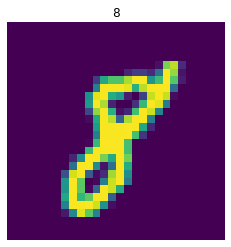

In [6]:
show(train_ims, train_labels, 17)

This is more or less how the classifier works, see: https://scikit-learn.org/stable/modules/naive_bayes.html

\begin{align}\begin{aligned}P(y \mid x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y)\\\Downarrow\\\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y),\end{aligned}\end{align}  

So we need the class probabilites for each class, which are just their relative frequencies and the feature probabilities for each class. We use the log-sum trick to replace the multiplication with a sum over the logs. To keep things a bit easier we transform the pixel values into binary features by rounding and have . The better way would be use gaussians or to use some kind of binning.

In [27]:
class Classifier: 

    def __init__(self):
        pass     
    
    def train(self, ims, labels):
        """ 
        Trains the classifier 
        """
        self.class_probs = self.compute_class_probs(labels)
        self.feature_probs = self.compute_feature_probs(labels,ims)
        
    
    def compute_class_probs(self, labels):
        """
        Returns the probabilities of each class
        """
        _, counts = np.unique(labels, return_counts=True)
        probs = counts / len(labels)
        return np.log(probs)
    
    
    def compute_feature_probs(self, labels, ims):
        """ 
        Returns the feature probabilities for each class
        """
        
        flattened = self.flatten(ims)
        classes, counts = np.unique(labels, return_counts=True)
        counts = np.expand_dims(counts, -1)
        
        fp = np.array([flattened[labels == n].sum(axis=0) for n in classes])
        
        # I think this lacks still the normalization/smoothing term which is only added before the log
        
        #fp = fp / fp.sum(axis=1, keepdims=True)  # should be Multinomial Naive Bayes
        fp = fp /  counts   # divide by counts should be Categorical Naive Bayes
        
        return fp 
    
    def flatten(self, ims): 
        """"
        Flattens a list of image matrices and converts values to 0/1 binary
        """
        return np.array([(x>0).flatten() for x in ims])  # rounding or binnign would also be possible
    
    def infer(self, ims):
        flattened = self.flatten(ims)

        return np.array([np.argmax(self.class_probs 
                                   + np.sum(np.log(self.feature_probs[:,ex==1]+1e-9), axis=1)
                                   + np.sum(np.log(1-self.feature_probs[:,ex==0]+1e-9), axis=1)  
                                   ) for ex in flattened])
    
    def get_probs(self):
        return self.class_probs, self.feature_probs


In [36]:
classifier = Classifier()
classifier.train(train_ims, train_labels)

In [37]:
inferred_labels = classifier.infer(test_ims)
acc = np.sum(inferred_labels == test_labels) / len(test_labels)
print(acc)

0.842


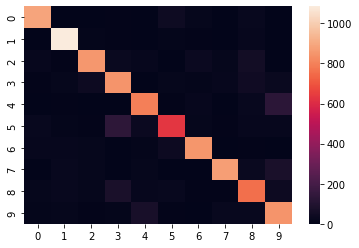

In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, inferred_labels)
sns.heatmap(cm);

# Visualize the features 
re-shaping the class features from the classifier shows what it learned.

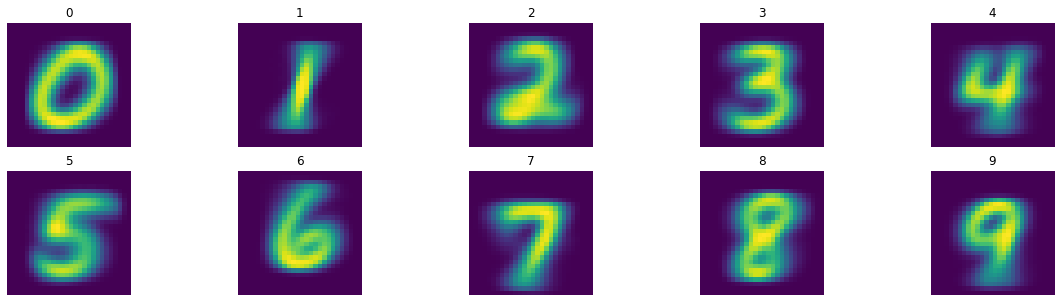

In [42]:
class_probs, feature_probs = classifier.get_probs()
fs = feature_probs.reshape([10,28,28])


fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(nrows=2, ncols=5)
for i in range(10):
    r, c = i // 5, i % 5
    axes[r][c].imshow(fs[i])
    axes[r][c].set_title(i)
   
    axes[r][c].axis('off')
plt.show()